=================================================

Graded Challenge 5

Nama  : Heru Ramadhan

Batch : HCK - 018

Notebook ini bertujuan untuk memahami konsep classification dengan model Logistic Regression, KNN, dan SVM. Classification ini dibuat untuk menentukan apakah customer/nasabah akan membayar atau gagal bayar pada bulan depan. Dataset yan digunakan dapat diakses <a href='https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=credit_card_default&page=table&project=myproject7-427010&ws=!1m5!1m4!4m3!1sbigquery-public-data!2sml_datasets!3scredit_card_default'>disini</a>

<a href='https://huggingface.co/spaces/Flickerjet/Credit_Card_Form'>Deployment</a>


=================================================

# Query SQL

Data dapat diakses dari BigQuery dengan ketentuan:

- Project_id: `bigquery-public-data`
- Dataset: `ml_datasets`
- Table: `credit_card_default`
- Pilih hanya kolom `limit_balance, sex, education_level, marital_status, age, pay_0, pay_2, pay_3, pay_4, pay_5, pay_6, bill_amt_1, bill_amt_2, bill_amt_3, bill_amt_4, bill_amt_5, bill_amt_6, pay_amt_1, pay_amt_2, pay_amt_3, pay_amt_4, pay_amt_5, pay_amt_6, default_payment_next_month` 
- Limit jumlah data menjadi sebanyak nomor batch dikali dengan tahun lahir = 18 x 1998 = 35964

- Pada kolom yang diambil diatas, terdapat beberapa kolom bertipe `STRING`. Pada saat pengambilan data dengan menggunakan perintah `SELECT`, lakukan konversi tipe data kolom-kolom bertipe `STRING` ke tipe numerik dengan panduan dibawah ini : 
     | Kolom | Tipe Data Awal | Tipe Data Akhir |
     | --- | --- | --- |
     | `sex` | STRING | INT |
     | `education_level` | STRING | INT |
     | `marital_status` | STRING | INT |
     | `pay_5` | STRING | FLOAT |
     | `pay_6` | STRING | FLOAT |
     | `default_payment_next_month` | STRING | INT |



Koneksikan data di atas menggunakan `BigQuery` ke Google Colab dengan code berikut:

---
```py
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')

project_id = "myproject7-427010"
client = bigquery.Client(project=project_id)
```
---

Untuk melakukan Query menggunakan cara ini, kamu dapat menggunakan method `client.query('Masukkan Querynya').to_dataframe()`. Outputnya akan berupa Pandas dataframe, sehingga harus import Pandas.


Contoh:

---

```py
df = client.query('''

SELECT limit_balance, cast(sex as int) as sex ,cast(education_level as int)as education_level,cast(marital_status as int) as marital_status, age, pay_0, pay_2, pay_3, pay_4, cast(pay_5 as float64) as pay_5, cast(pay_6 as float64) as pay_6, bill_amt_1, bill_amt_2, bill_amt_3, bill_amt_4, bill_amt_5, bill_amt_6, pay_amt_1, pay_amt_2, pay_amt_3, pay_amt_4, pay_amt_5, pay_amt_6, cast(default_payment_next_month as int) as default_payment_next_month
FROM `bigquery-public-data.ml_datasets.credit_card_default`
limit 35964

''').to_dataframe()

df
```

---

# Import Libraries

In [1]:
# Import Libraries yang dibutuhkan
import pandas as pd
import numpy as np

# library untuk visualisasi data
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# libary untuk train test split data
from sklearn.model_selection import train_test_split

# library untuk capping data
from feature_engine.outliers import Winsorizer

# library untuk korelasi check
from scipy.stats import kendalltau, spearmanr, chi2_contingency

# library untuk encoding
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Scaler
from sklearn.preprocessing import MinMaxScaler

# Model
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Random search 
from sklearn.model_selection import RandomizedSearchCV

# cross validation
from sklearn.model_selection import cross_val_score

# performance check
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score

# Library for warnings
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# model saving
import pickle

# Data Loading

In [2]:
# melakukan penambahan csv kedalam sebuah dataframe
df = pd.read_csv('/Users/Heru/HCK18/Phase 1/GC5/p1-ftds018-hck-g5-herurmdn7/P1G5_Set_1_Heru.csv')

# melakukan concat untuk memperlihatkan top 10 dan bottom 10
topBottom = pd.concat([df.head(10), df.tail(10)])

# memanggil variabel yang sudah diconcat
topBottom

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,0.0,...,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,...,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,...,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,...,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,...,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


## Data Info

In [3]:
# Melihat informasi mengenai dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

**Setelah melakukan data loading, didapati data sebagai berikut:**
- Data memiliki 24 kolom
- Data berjumlah 2965 baris
- Data memiliki 20 tipe float64
- Data memiliki 4 tipe integer
- Data tidak memiliki tipe object

| fullname | type | description |
|---|---|---|
| limit_balance | FLOAT | Amount of given credit in NT dollars (includes individual and family/supplementary credit |
| sex | INT | Gender (1=male, 2=female) |
| education_level | INT | Education Level (1=graduate school, 2=university, 3=high school, 0,4,5,6 = others) |
| marital_status | INT | Marital status (1=married, 2=single, 3=divorce, 0 = others) |
| age | FLOAT | Age in years |
| pay_0 | FLOAT | Repayment status in September, 2005 (-2= No consumption, -1=pay duly,0= The use of revolving credit,  1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above) |
| pay_2 | FLOAT | Repayment status in August, 2005 (scale same as above) |
| pay_3 | FLOAT | Repayment status in July, 2005 (scale same as above) |
| pay_4 | FLOAT | Repayment status in June, 2005 (scale same as above) |
| pay_5 | FLOAT | Repayment status in May, 2005 (scale same as above) |
| pay_6 | FLOAT | Repayment status in April, 2005 (scale same as above) |
| bill_amt_1 | FLOAT | Amount of bill statement in September, 2005 (NT dollar) |
| bill_amt_2 | FLOAT | Amount of bill statement in August, 2005 (NT dollar) |
| bill_amt_3 | FLOAT | Amount of bill statement in July, 2005 (NT dollar) |
| bill_amt_4 | FLOAT | Amount of bill statement in June, 2005 (NT dollar) |
| bill_amt_5 | FLOAT | Amount of bill statement in May, 2005 (NT dollar) |
| bill_amt_6 | FLOAT | Amount of bill statement in April, 2005 (NT dollar) |
| pay_amt_1 | FLOAT | Amount of previous payment in September, 2005 (NT dollar) |
| pay_amt_2 | FLOAT | Amount of previous payment in August, 2005 (NT dollar) |
| pay_amt_3 | FLOAT | Amount of previous payment in July, 2005 (NT dollar) |
| pay_amt_4 | FLOAT | Amount of previous payment in June, 2005 (NT dollar) |
| pay_amt_5 | FLOAT | Amount of previous payment in May, 2005 (NT dollar) |
| pay_amt_6 | FLOAT | Amount of previous payment in April, 2005 (NT dollar) |
| default_payment_next_month | INT | Default payment (1=yes, 0=no) |


## Data duplication and missing value check

In [4]:
# cek duplikat pada data
print('jumlah duplikasi data: ', df.duplicated().sum())

# cek missing values pada data
print('jumlah missing value pada data: ', df.isnull().sum())

jumlah duplikasi data:  1
jumlah missing value pada data:  limit_balance                 0
sex                           0
education_level               0
marital_status                0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt_1                    0
bill_amt_2                    0
bill_amt_3                    0
bill_amt_4                    0
bill_amt_5                    0
bill_amt_6                    0
pay_amt_1                     0
pay_amt_2                     0
pay_amt_3                     0
pay_amt_4                     0
pay_amt_5                     0
pay_amt_6                     0
default_payment_next_month    0
dtype: int64


**Setelah melakukan pengecekan terhadap duplikasi data dan missing values, didapati data sebagai berikut:**
- terdapat 1 duplikasi data pada dataframe tersebut
- tidak terdapat missing value pada datafrane tersebut

# Exploratory Data Analysis (EDA)

In [5]:
# melakukan copy pada dataframe
df1 = df.copy()

# memperlihatkan 10 row teratas dari dataframe tersebut
df1.head(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,0.0,...,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,...,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,...,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,...,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,...,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


## Average Credit limit by Gender

In [6]:
# Average credit limit by gender
avgCreditGender = df1.groupby('sex')['limit_balance'].mean().sort_values(ascending=False).reset_index()

# urutan
urutanGender = {1: 'male', 2: 'female'}

# apply urutan
avgCreditGender['sex'] = avgCreditGender['sex'].map(urutanGender)

fig = px.pie(avgCreditGender, names="sex", 
              values="limit_balance", 
              title="Credit limit by Gender",
              hover_data=["limit_balance"], 
              )
fig.show()

avgCreditGender

,sex,limit_balance
0,female,166237.513873
1,male,158925.193465


- Female memiliki rata rata limit balance tertinggi dengan jumlah 166237.513873
- Male memiliki rata rata limit balance terendah dengan jumlah 158925.19346

## Average Credit limit by Education Level

In [7]:
# Average credit limit by gender
avgCreditEdu = df1.groupby('education_level')['limit_balance'].mean().sort_values(ascending=False).reset_index()

# urutan
urutanEdu = {0: 'others', 1: 'graduate school', 2: 'university', 3: 'high school', 4: 'others 1', 5: 'others 2', 6: 'others 3'}

# apply urutan
avgCreditEdu['education_level'] = avgCreditEdu['education_level'].map(urutanEdu)

fig = px.bar(avgCreditEdu, x='education_level', y='limit_balance', orientation='v',text_auto='.2s')
fig.show()

avgCreditEdu

,education_level,limit_balance
0,others 1,227692.307692
1,graduate school,206025.024062
2,others,175000.000000
3,others 2,155416.666667
4,university,144964.285714
5,high school,124409.937888
6,others 3,62500.000000


**Berdasarkan informasi bar chart diatas, dapat disimpulkan bahwa:**<br>
- others 1 dan graduate school memiliki nilai rata rata limit balance paling tinggi diantara education level yang lain.
- rata rata nilai limit balance untuk lulusan highschool memiliki nilai paling rendah diantara graduate school dan university

## Total Marital Status

In [8]:
totalMarital = df1['marital_status'].value_counts().reset_index()

# urutan
urutanMarital = {0: 'others', 1: 'married', 2: 'single', 3: 'divorce'}

# apply urutan
totalMarital['marital_status'] = totalMarital['marital_status'].map(urutanMarital)

fig = px.bar(totalMarital, x='marital_status', y='count', orientation='v',text_auto='.2s')
fig.show()

totalMarital

,marital_status,count
0,single,1594
1,married,1332
2,divorce,35
3,others,4


**Berdasarkan informasi bar chart diatas, dapat disimpulkan bahwa:**<br>
- Terdapat sebesar 1.594 customer yang berstatus single
- Terdapat sebesar 1.332 customer yang berstatus married
- Terdapat sebesar 35 customer yang berstatus divorced
- Terdapat sebesar 4 customer yang berstatus tidak diketahui


## Average Education level by Age

In [9]:
# Median age by education level
avgAgeEdu = df1.groupby('education_level')['age'].median().sort_values(ascending=False).reset_index()

# urutan
urutanEdu = {0: 'others', 1: 'graduate school', 2: 'university', 3: 'high school', 4: 'others 1', 5: 'others 2', 6: 'others 3'}

# apply urutan
avgAgeEdu['education_level'] = avgAgeEdu['education_level'].map(urutanEdu)

fig = px.bar(avgAgeEdu, x='education_level', y='age', orientation='v',text_auto='.2s')
fig.show()

avgAgeEdu

,education_level,age
0,high school,41.0
1,others,36.0
2,others 2,33.5
3,university,33.0
4,graduate school,32.0
5,others 1,32.0
6,others 3,29.5


**Berdasarkan informasi bar chart diatas, dapat disimpulkan bahwa:**<br>
- Education level berstatus high school memiliki rata rata berumur 41 tahun
- Education level berstatus university memiliki rata rata berumur 33 tahun
- Education level berstatus graduate school memiliki rata rata berumur 32 tahun
- untuk education level lainnya memiliki rata rata umur yang beragam.

## Total Payment Amounts by Education Level

In [48]:
# Total payment amounts by education level
totalPaymentEdu = df1.groupby('education_level')[['pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']].sum().reset_index()
totalPaymentEdu['Total Payment'] = totalPaymentEdu[['pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']].sum(axis=1)

# Melt the dataframe for easier plotting
totalPaymentEdu2 = totalPaymentEdu.melt(id_vars='education_level', value_vars=['pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6'],
                                              var_name='Payment Month', value_name='Total payment')

# apply urutan
totalPaymentEdu2['education_level'] = totalPaymentEdu2['education_level'].map(urutanEdu)

# Create the bar chart
fig = px.bar(totalPaymentEdu2, x='education_level', y='Total payment', color='Payment Month',
             title='Total Payment Amounts by Education Level', labels={'education_level': 'Education Level', 'Total Payment': 'Total Payment Amount'})

fig.show()


totalPaymentEdu


,education_level,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,Total Payment
0,0,7783.0,12046.0,33718.0,0.0,1190.0,590.0,55327.0
1,1,7547729.0,8513195.0,6477099.0,5279700.0,6049669.0,7224300.0,41091692.0
2,2,8266177.0,7011122.0,6235973.0,5773394.0,6441162.0,6093225.0,39821053.0
3,3,2852503.0,2547504.0,2156180.0,2258031.0,1895178.0,2348723.0,14058119.0
4,4,48564.0,205904.0,206505.0,69295.0,37816.0,19412.0,587496.0
5,5,91323.0,296283.0,152824.0,140988.0,140448.0,272722.0,1094588.0
6,6,10418.0,11892.0,8925.0,3072.0,2432.0,738.0,37477.0


**Berdasarkan informasi bar chart diatas, dapat disimpulkan bahwa:**<br>
- Education Level 1 ( graduate school ) cenderung memiliki total payment yang lebih tinggi dibandingkan lainnya
- Education level 3 ( high school ) memiliki total payment yang paling rendah diantara lulusan graduate school dan university

## Totals of Default Payment by Education Level

In [49]:
# Count of defaults by education level
defaultEdu = df1.groupby('education_level')['default_payment_next_month'].sum().reset_index()

# apply urutan
defaultEdu['education_level'] = defaultEdu['education_level'].map(urutanEdu)

fig = px.bar(defaultEdu, x='education_level', y='default_payment_next_month', orientation='v',text_auto='.2s')
fig.show()

defaultEdu


,education_level,default_payment_next_month
0,others,0
1,graduate school,177
2,university,342
3,high school,113
4,others 1,0
5,others 2,1
6,others 3,2


**Berdasarkan informasi bar chart diatas, dapat disimpulkan bahwa:**<br>
- berdasarkan dataset, lulusan university memiliki data gagal bayar yang paling besar diantara lainnya
- untuk lulusan high school dan graduated school memiliki nilai data gagal bayar yang tidak jauh beda.

## Totals of Default Payment by Marital Status

In [50]:
# Count of defaults by marital status
defaultMarital = df1.groupby('marital_status')['default_payment_next_month'].sum().reset_index()
# apply urutan
defaultMarital['marital_status'] = defaultMarital['marital_status'].map(urutanMarital)

fig = px.bar(defaultMarital, x='marital_status', y='default_payment_next_month', orientation='v',text_auto='.2s')
fig.show()

defaultMarital


,marital_status,default_payment_next_month
0,others,0
1,married,302
2,single,327
3,divorce,6


**Berdasarkan informasi bar chart diatas, dapat disimpulkan bahwa:**<br>
- Berdasarkan dataset, customer berstatus single memiliki nilai gagal bayar yang tinggi diikuti dengan customer yang berstatus married

# Feature Engieering

In [13]:
# melakukan copy pada dataframe
df2 = df.copy()

# memperlihatkan 10 row teratas dari dataframe tersebut
df2.head(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,0.0,...,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,...,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,...,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,...,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,...,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


## Handling Missing Values

In [14]:
# cek duplikat pada data
print('jumlah duplikasi data: ', df2.duplicated().sum())

# cek missing values pada data
print('jumlah missing value pada data: ', df2.isnull().sum())

jumlah duplikasi data:  1
jumlah missing value pada data:  limit_balance                 0
sex                           0
education_level               0
marital_status                0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt_1                    0
bill_amt_2                    0
bill_amt_3                    0
bill_amt_4                    0
bill_amt_5                    0
bill_amt_6                    0
pay_amt_1                     0
pay_amt_2                     0
pay_amt_3                     0
pay_amt_4                     0
pay_amt_5                     0
pay_amt_6                     0
default_payment_next_month    0
dtype: int64


Terdapat 1 duplikasi pada dataset dan 0 missing values pada dataset.

In [15]:
# remove duplicates
df2.drop_duplicates(inplace=True)
print('jumlah duplikasi data: ', df2.duplicated().sum())

jumlah duplikasi data:  0


## Cardinality Test


In [16]:
# mengelompokan kategorikal kolom
categorical = ['sex','education_level','marital_status', 'pay_0','pay_2','pay_3','pay_4','pay_5','pay_6' ]

In [17]:
# membuat function untuk cek cardinalitas data
def cardinality_func(dataframe):

    # membuat empty list
    columns = []
    nunique = []
    unique = []

    # memilih kolom bertipe object
    categorical = ['sex','education_level','marital_status', 'pay_0','pay_2','pay_3','pay_4','pay_5','pay_6' ]
    for column in categorical:
        columns.append(column)
        nunique.append(dataframe[column].nunique())
        unique.append(dataframe[column].unique())

    # membuat dataframe 
    cardinality_df = pd.DataFrame({
    'nama kolom' : columns,
    'jumlah unique' : nunique,
    'unique':unique})

    return cardinality_df

# memanggil function 
cardinality_func(df2)

,nama kolom,jumlah unique,unique
0,sex,2,"[1, 2]"
1,education_level,7,"[6, 4, 1, 2, 3, 5, 0]"
2,marital_status,4,"[1, 2, 3, 0]"
3,pay_0,11,"[0.0, 2.0, 1.0, -1.0, -2.0, 3.0, 4.0, 5.0, 6.0..."
4,pay_2,10,"[0.0, -1.0, 2.0, 3.0, -2.0, 4.0, 1.0, 5.0, 6.0..."
5,pay_3,9,"[0.0, 2.0, -2.0, 3.0, -1.0, 4.0, 5.0, 6.0, 7.0]"
6,pay_4,10,"[0.0, -1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
7,pay_5,9,"[0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, -1.0, -2.0]"
8,pay_6,8,"[0.0, -1.0, 2.0, 3.0, -2.0, 4.0, 6.0, 7.0]"


Data memiliki nilai kardinalitas yang rendah dan rentang kardinalitas yang sama antar kolom

## Split Train Test

In [18]:
# Melakukan split data menjadi X dan Y
# X berisi kolom selain target
X = df2.drop(['default_payment_next_month'],axis=1)

# Y berisi kolom target
y = df2['default_payment_next_month']

In [19]:
# melakukan split data dengan menggunakan 15% data sebagai data testing dan randomisasi 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=14)

In [20]:
# display top 5 row data
X_train.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
235,80000.0,2,1,2,22.0,0.0,0.0,0.0,0.0,0.0,...,76022.0,58897.0,54512.0,51937.0,3200.0,2229.0,1900.0,4000.0,5000.0,21000.0
324,360000.0,2,1,2,27.0,0.0,0.0,0.0,0.0,0.0,...,23707.0,24145.0,24068.0,24350.0,1800.0,1800.0,1000.0,1649.0,1003.0,3.0
122,500000.0,2,1,1,34.0,0.0,0.0,0.0,0.0,0.0,...,60927.0,76088.0,110294.0,108964.0,15000.0,30007.0,30000.0,50000.0,5000.0,5000.0
2229,80000.0,1,1,1,41.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,10926.0,3355.0,6127.0,25675.0,8739.0,10926.0,3362.0,6127.0,25675.0,7606.0
1481,60000.0,1,3,2,31.0,2.0,2.0,2.0,2.0,0.0,...,34336.0,33489.0,35615.0,38027.0,0.0,4000.0,0.0,3000.0,3000.0,2000.0


In [21]:
# Check ukuran data
print(f'Train set : {X_train.shape}')
print(f'test set : {X_test.shape}')

Train set : (2519, 23)
test set : (445, 23)


- Data Trainset berukuran 2519 row dan 23 kolom
- Data Test set berukuran 445 row dan 23 kolom

## Outlier Handling

In [22]:
# Membuat function untuk menghitung nilai skew, upper dan lower boundary, dan outlier
def outlier_analysis(data):

    # membuat dataframe dan empty list
    result = pd.DataFrame()
    col_name = []
    skew = []
    upper = []
    lower = []
    type = []
    has_outliers = [] 

    # menseleksi kolom dengan memilih numerik kolom saja
    num_columns = data.select_dtypes(include=['int64','float64'])

    # melakukan pengecualian terhadap beberapa kolom yang merupakan kolom categorical 
    num_columns1 = num_columns[num_columns.columns.difference(['sex','education_level','marital_status', 'pay_0','pay_2','pay_3','pay_4','pay_5','pay_6' ])]
    # Loop 
    for col in num_columns1:
        col_name.append(col)

        # skewness
        skew_val = data[col].skew()
        skew.append(skew_val)

        # extreme skewed upper and lower boundaries
        if skew_val > 1 or skew_val < -1:
            IQR = data[col].quantile(0.75) - data[col].quantile(0.25)

            lower_boundary = data[col].quantile(0.25) - (IQR * 3)
            upper_boundary = data[col].quantile(0.75) + (IQR * 3)
            type.append('extreme skew')

        # Moderate skewed
        elif skew_val >= 0.5 or skew_val <= -0.5:
            IQR = data[col].quantile(0.75) - data[col].quantile(0.25)

            lower_boundary = data[col].quantile(0.25) - (IQR * 1.5)
            upper_boundary = data[col].quantile(0.75) + (IQR * 1.5)
            type.append('moderate skew')

        # Normal
        else:
            std = data[col].quantile(0.75) - data[col].quantile(0.25)

            lower_boundary = data[col].mean() - (std * 3)
            upper_boundary = data[col].mean() + (std * 3)
            type.append('normal skew')
        
        # append nilai upper dan lower ke empty list 
        upper.append(upper_boundary)
        lower.append(lower_boundary)
        
        # pengecekan outlier
        outliers = (data[col] < lower_boundary) | (data[col] > upper_boundary)
        has_outliers.append(any(outliers))

    # Menambahkan list sebelumnya ke dalam sebuah dataframe
    result['columns'] = col_name
    result['skewness'] = skew
    result['upper boundary'] = upper
    result['lower boundary'] = lower
    result['skew type'] = type
    result['has_outliers'] = has_outliers  

    return result

# memanggil function dan membuat variabel baru
X_train_boundaries = outlier_analysis(X_train)

# memanggil variabel
X_train_boundaries

,columns,skewness,upper boundary,lower boundary,skew type,has_outliers
0,age,0.779167,60.5,8.5,moderate skew,True
1,bill_amt_1,2.490913,265490.0,-191897.0,extreme skew,True
2,bill_amt_2,2.460240,259768.0,-188841.0,extreme skew,True
3,bill_amt_3,2.527356,242092.0,-175762.5,extreme skew,True
4,bill_amt_4,2.425051,225493.5,-164490.5,extreme skew,True
5,bill_amt_5,2.366906,207720.5,-152230.0,extreme skew,True
6,bill_amt_6,2.377194,204068.0,-150496.0,extreme skew,True
7,limit_balance,0.992745,525000.0,-235000.0,moderate skew,True
8,pay_amt_1,10.672408,17157.5,-11024.5,extreme skew,True
9,pay_amt_2,16.560092,17000.0,-11000.0,extreme skew,True


Semua numerical kolom memiliki nilai outliers dan tidak ada yang berdistribusi normal

In [23]:
haveOutlier = X_train_boundaries[(X_train_boundaries['has_outliers']==True)]['columns'].tolist()
haveOutlier

['age',
 'bill_amt_1',
 'bill_amt_2',
 'bill_amt_3',
 'bill_amt_4',
 'bill_amt_5',
 'bill_amt_6',
 'limit_balance',
 'pay_amt_1',
 'pay_amt_2',
 'pay_amt_3',
 'pay_amt_4',
 'pay_amt_5',
 'pay_amt_6']

List kolom yang mempunyai outliers adalah:
- `age`
- `bill_amt_1`
- `bill_amt_2`
- `bill_amt_3`
- `bill_amt_4`
- `bill_amt_5`
- `bill_amt_6`
- `limit_balance`
- `pay_amt_1`
- `pay_amt_2`
- `pay_amt_3`
- `pay_amt_4`
- `pay_amt_5`
- `pay_amt_6`

In [24]:
# filter data yang mempunyai distribusi moderate dan extreme
restskew = X_train_boundaries[(X_train_boundaries['skew type']=='extreme skew')]['columns'].tolist() + ['age','limit_balance']
# Capping 
winsoriser_fare = Winsorizer(
    capping_method='iqr',
    tail='both',
    fold=1.5,
    variables=restskew
)

X_train_capped = winsoriser_fare.fit_transform(X_train)
X_test_capped = winsoriser_fare.transform(X_test)

In [25]:
# function untuk membuat histogram dan boxplot
def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

age - Before Capping


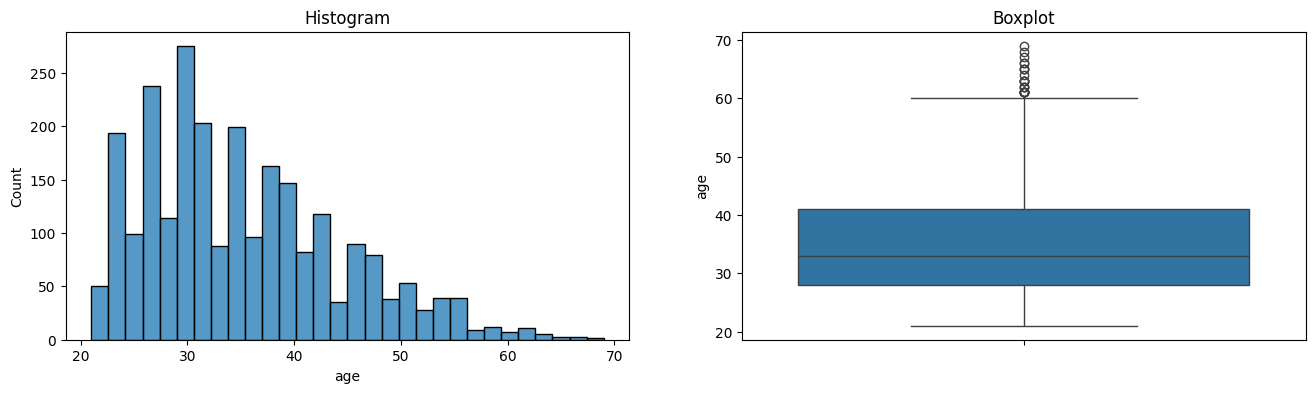


age - After Capping


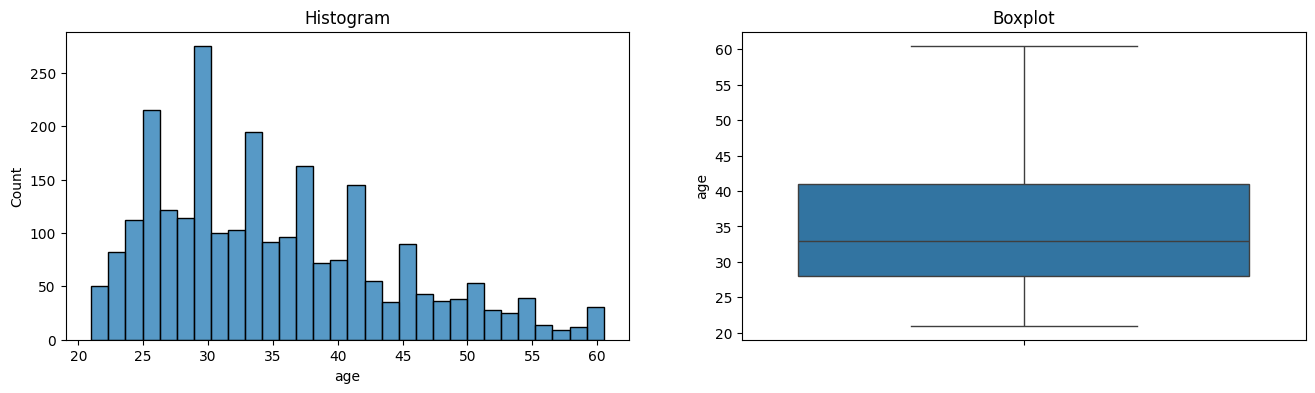

bill_amt_1 - Before Capping


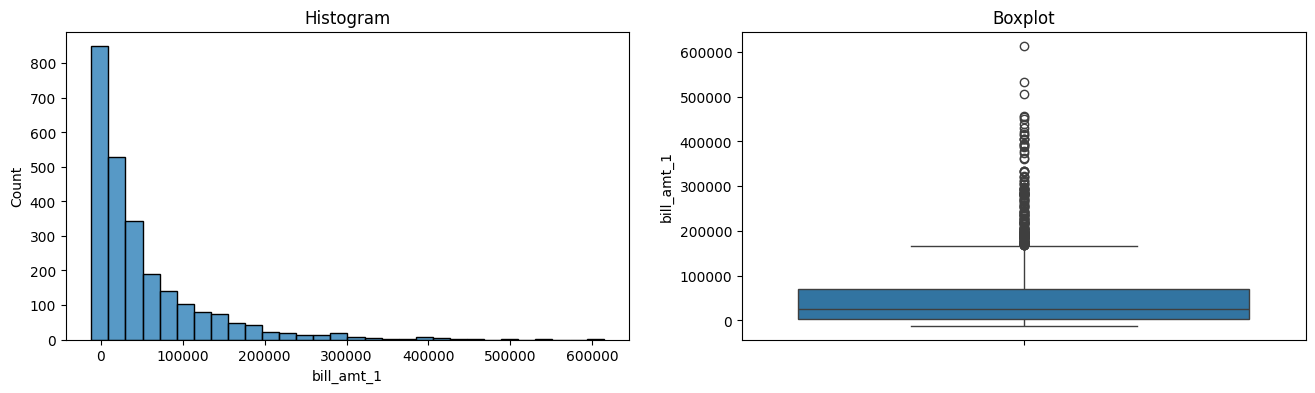


bill_amt_1 - After Capping


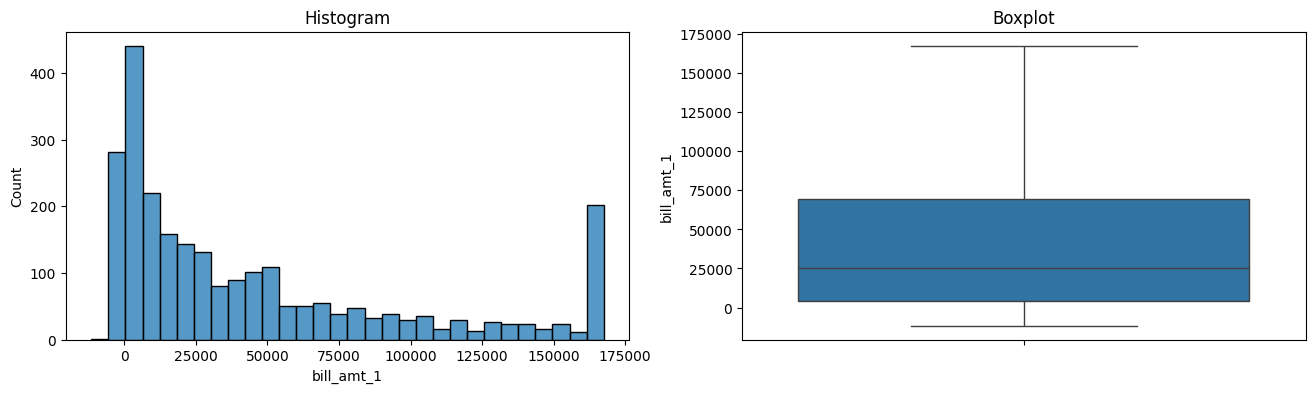

bill_amt_2 - Before Capping


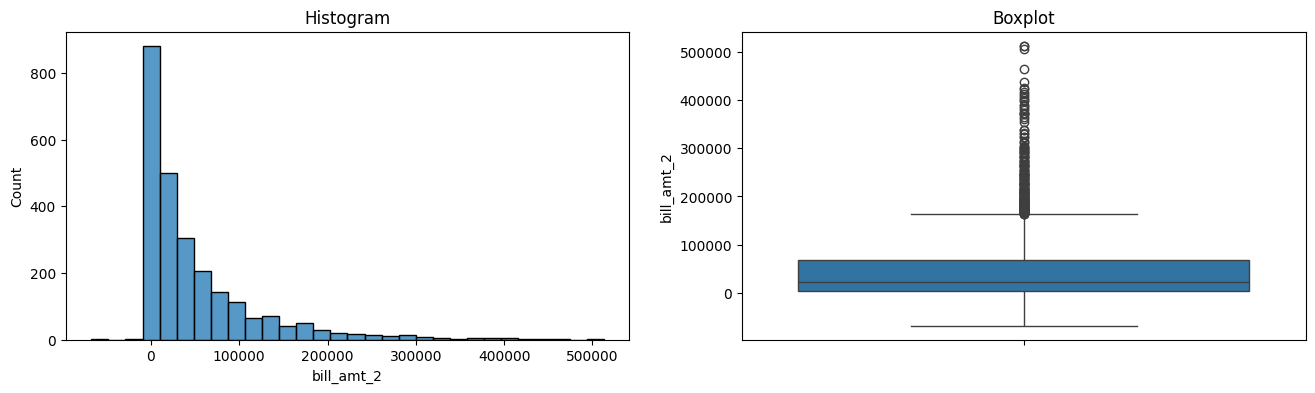


bill_amt_2 - After Capping


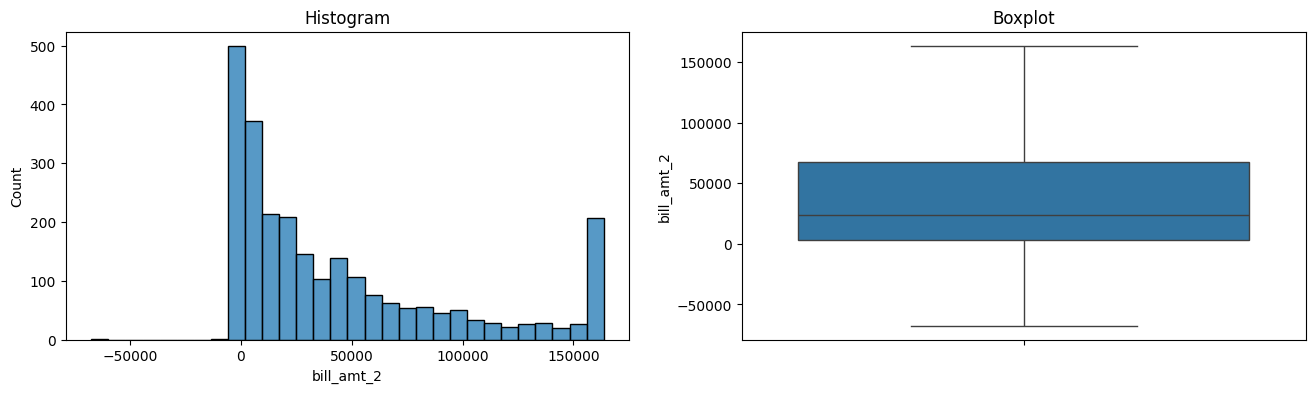

bill_amt_3 - Before Capping


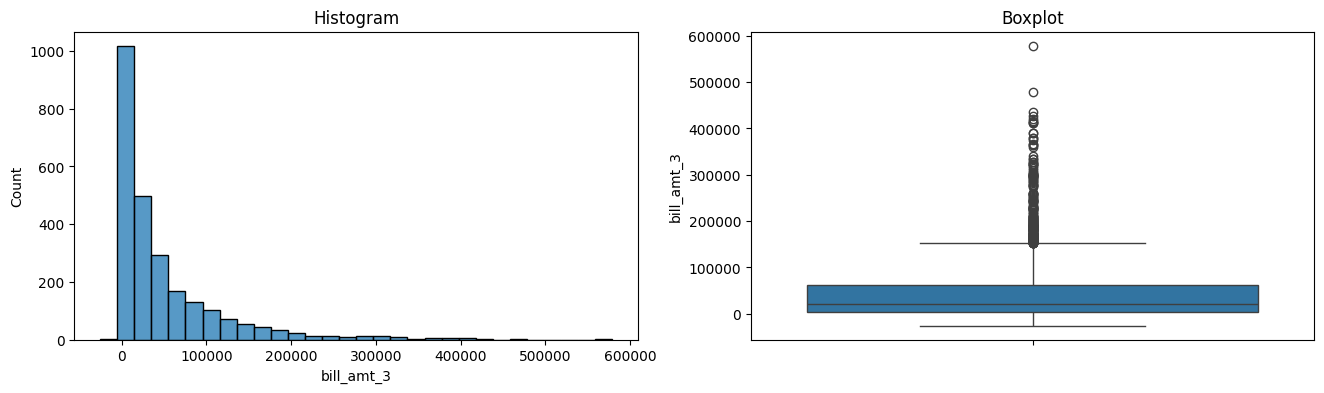


bill_amt_3 - After Capping


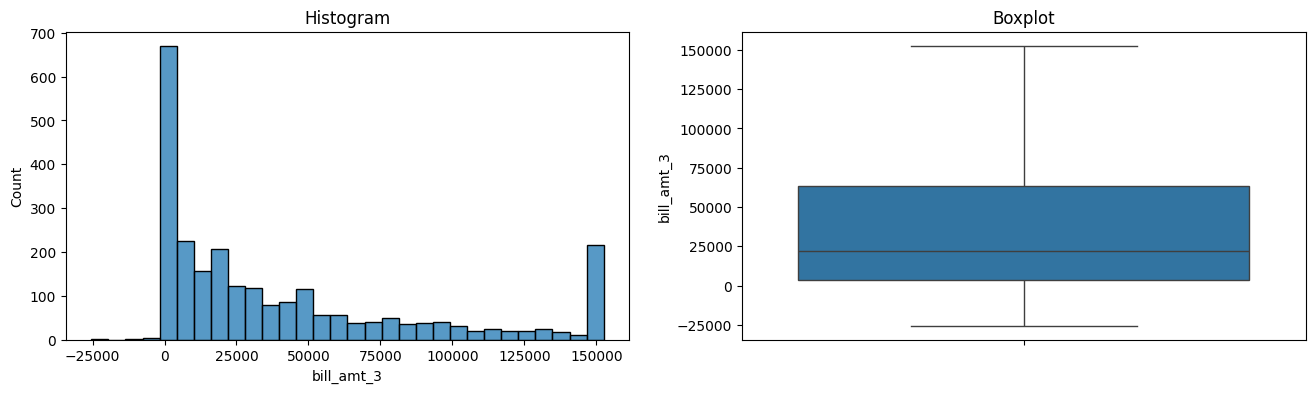

bill_amt_4 - Before Capping


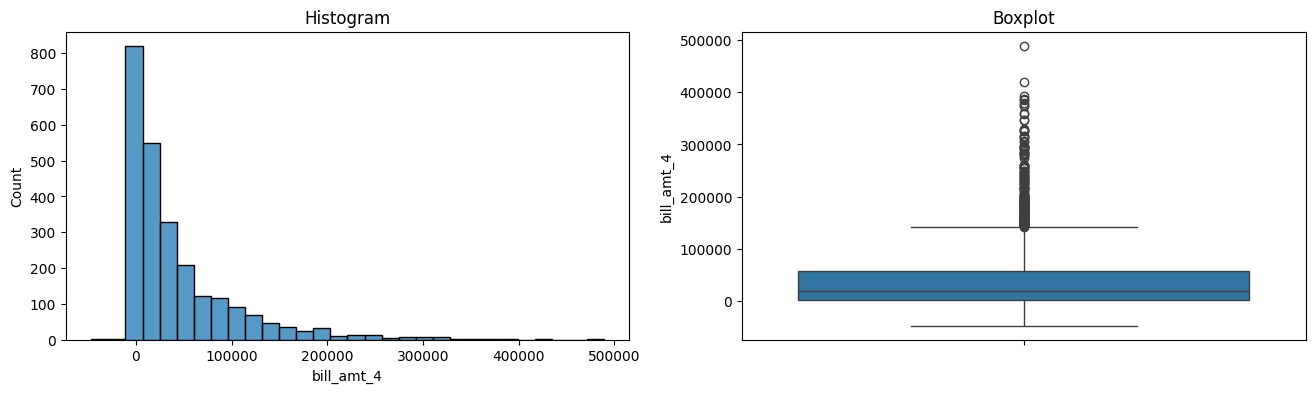


bill_amt_4 - After Capping


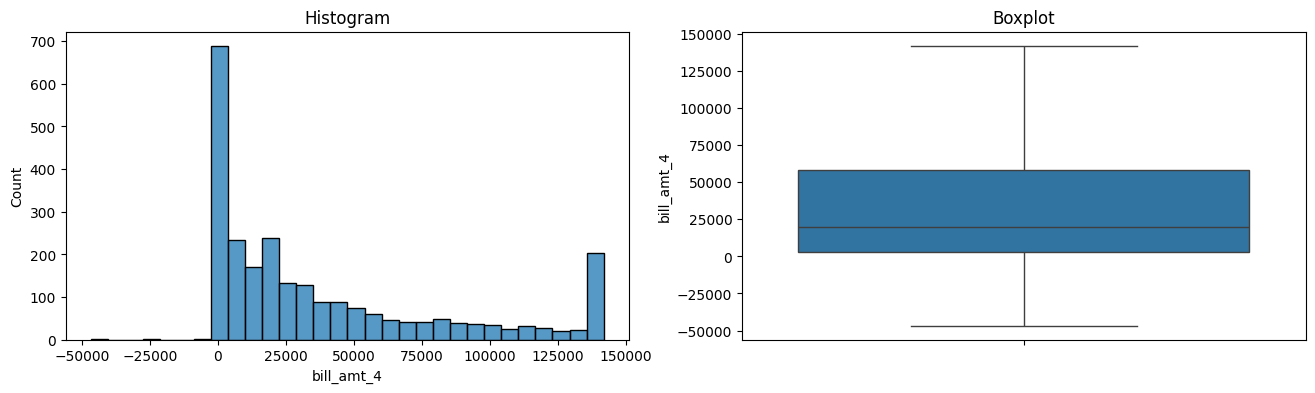

bill_amt_5 - Before Capping


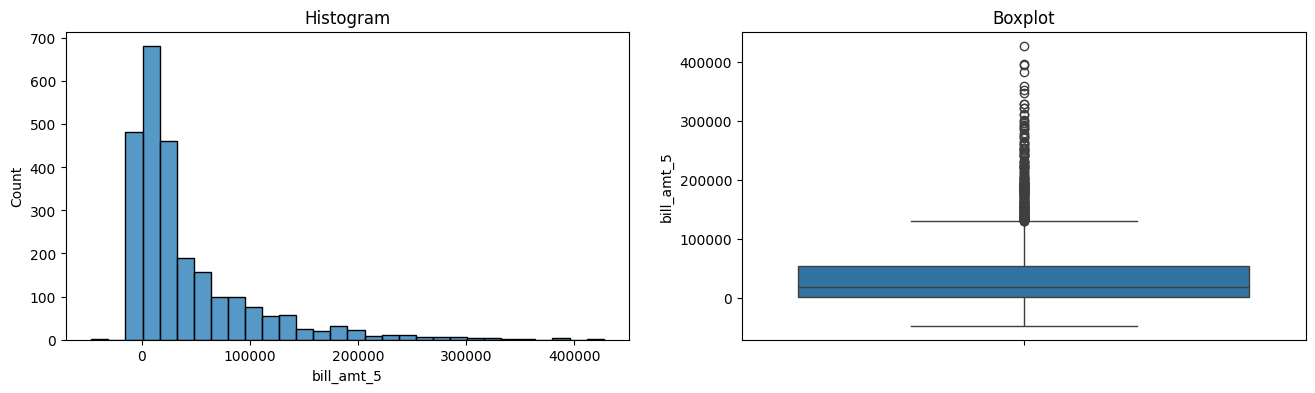


bill_amt_5 - After Capping


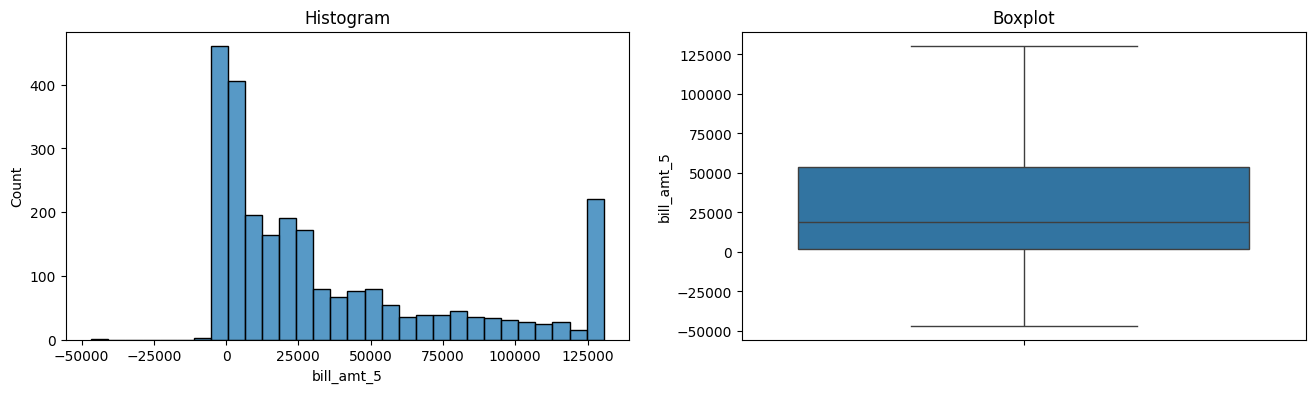

bill_amt_6 - Before Capping


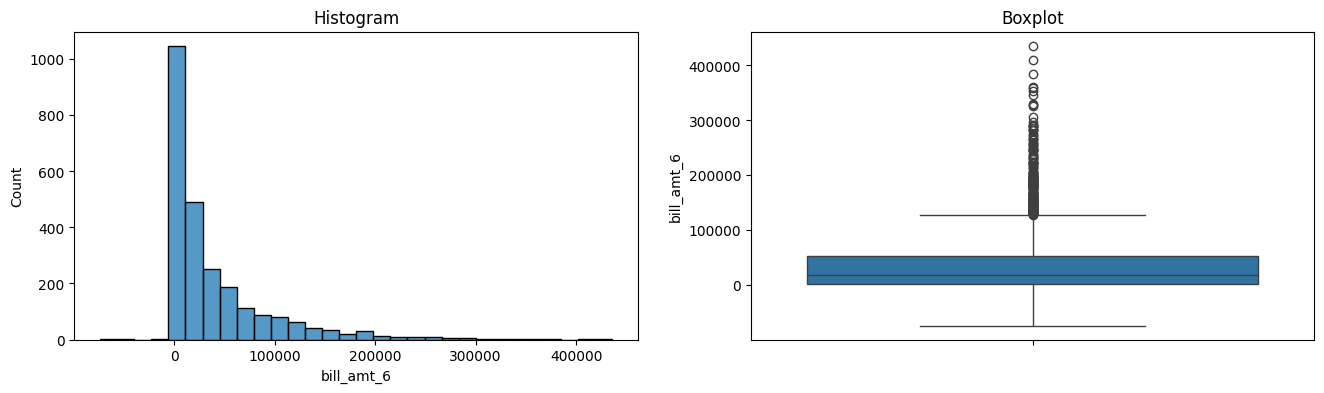


bill_amt_6 - After Capping


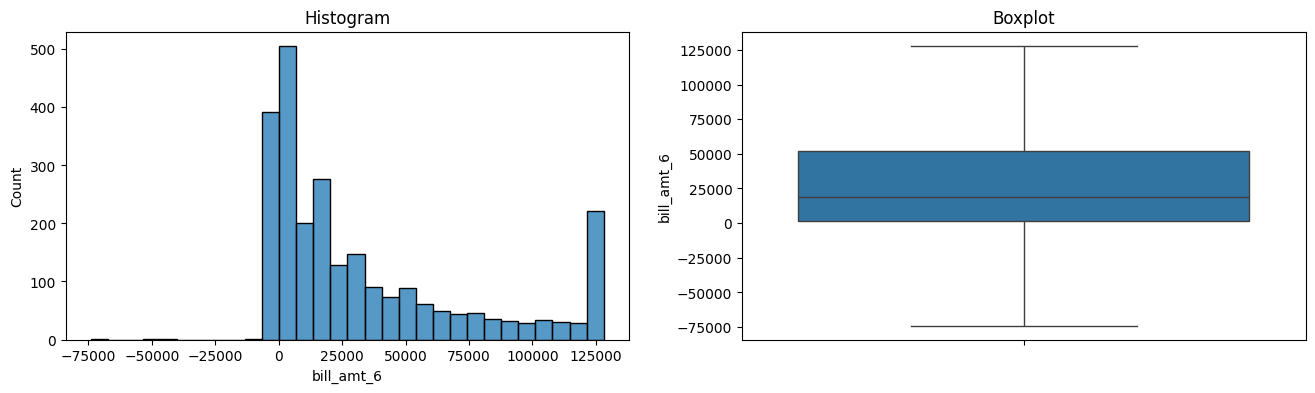

limit_balance - Before Capping


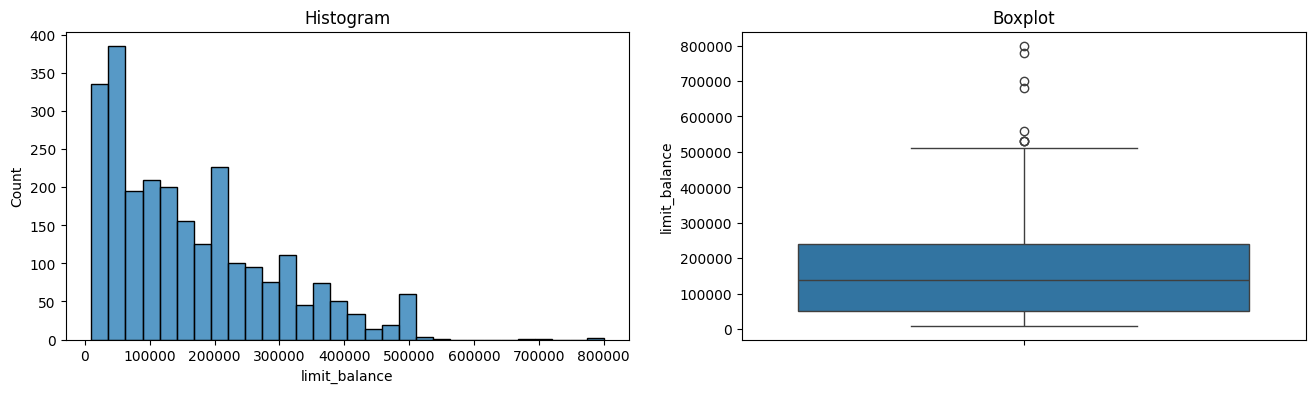


limit_balance - After Capping


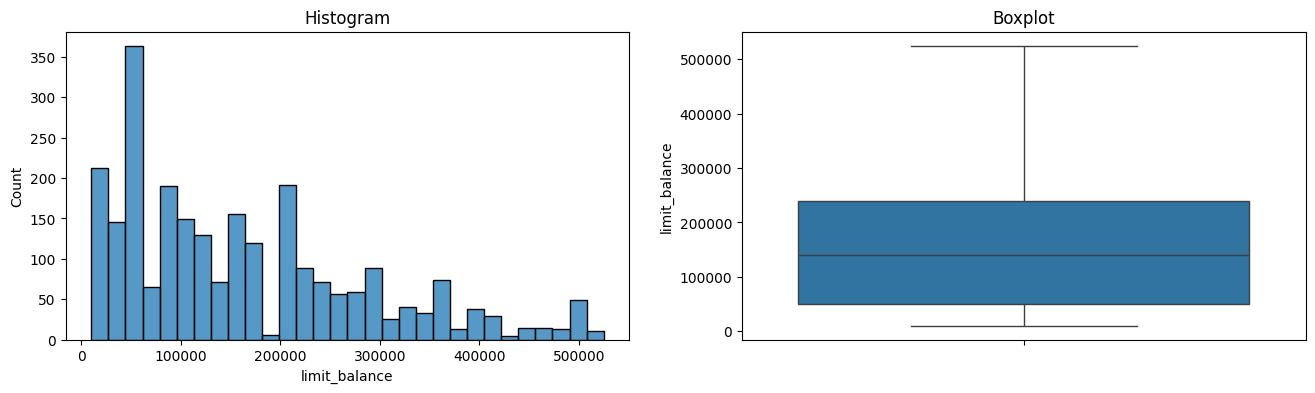

pay_amt_1 - Before Capping


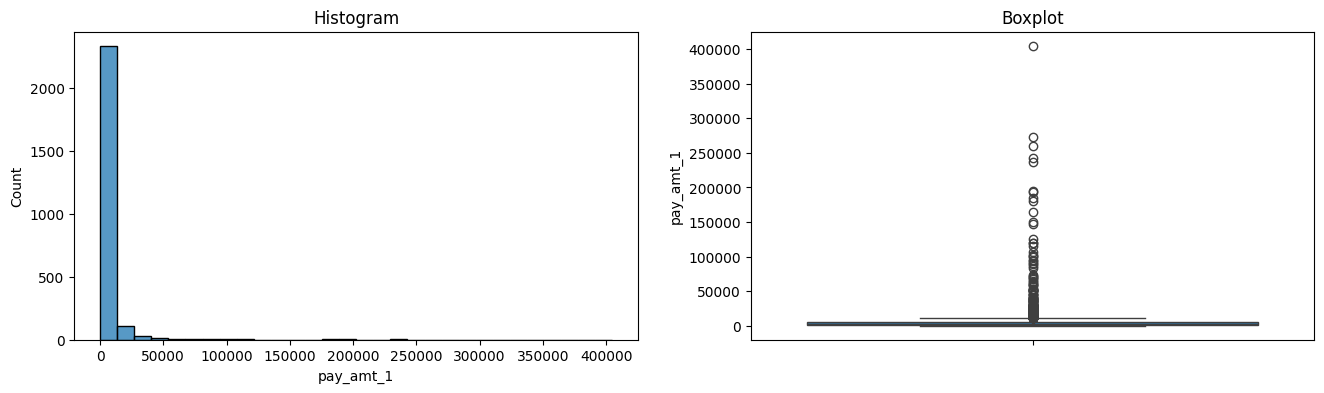


pay_amt_1 - After Capping


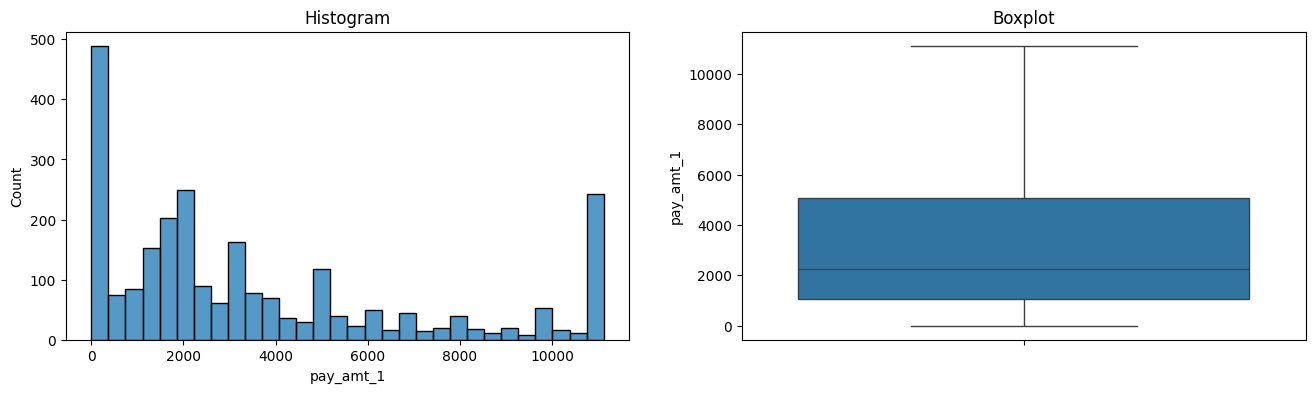

pay_amt_2 - Before Capping


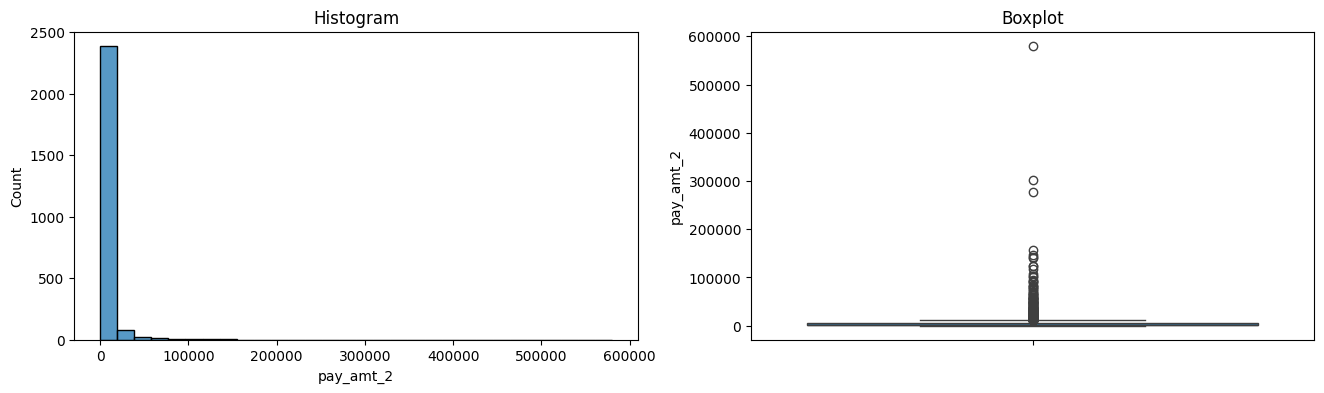


pay_amt_2 - After Capping


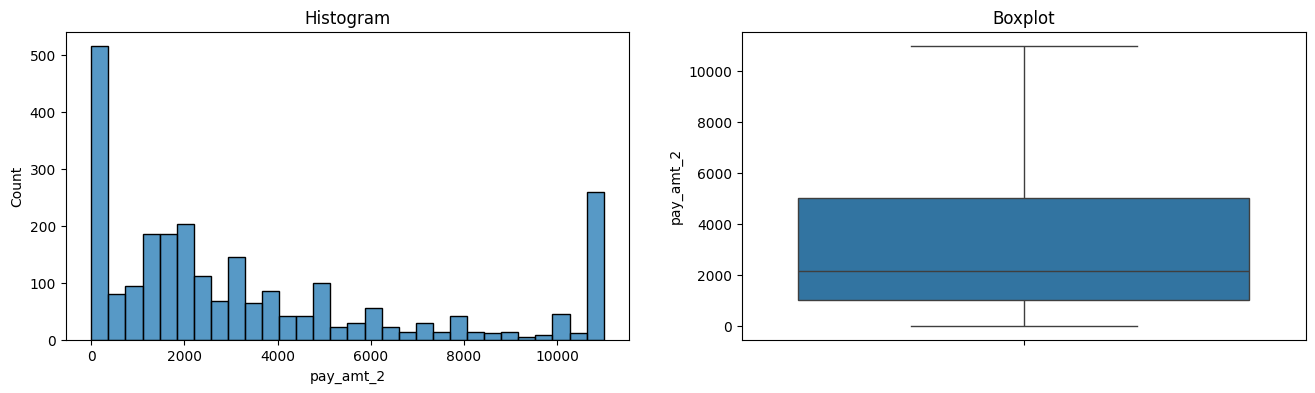

pay_amt_3 - Before Capping


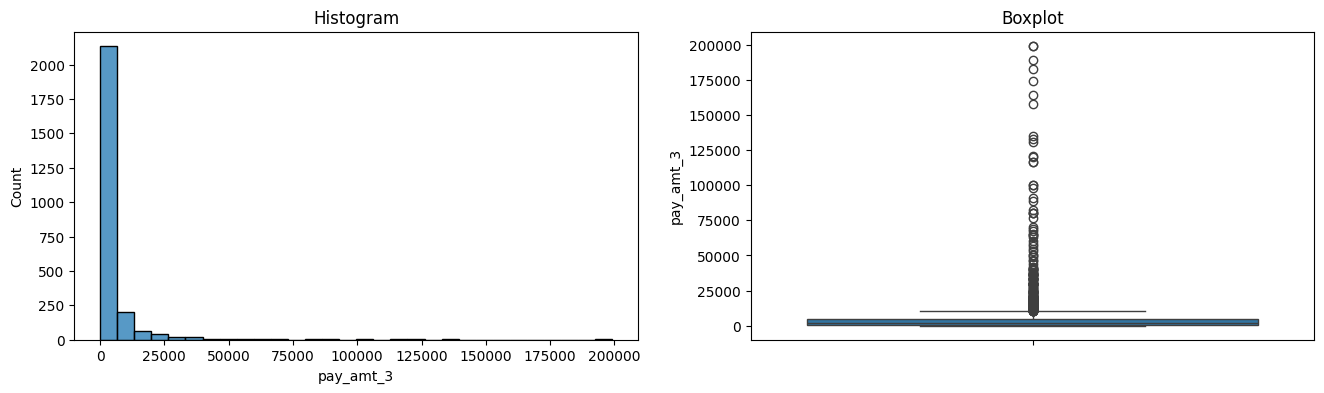


pay_amt_3 - After Capping


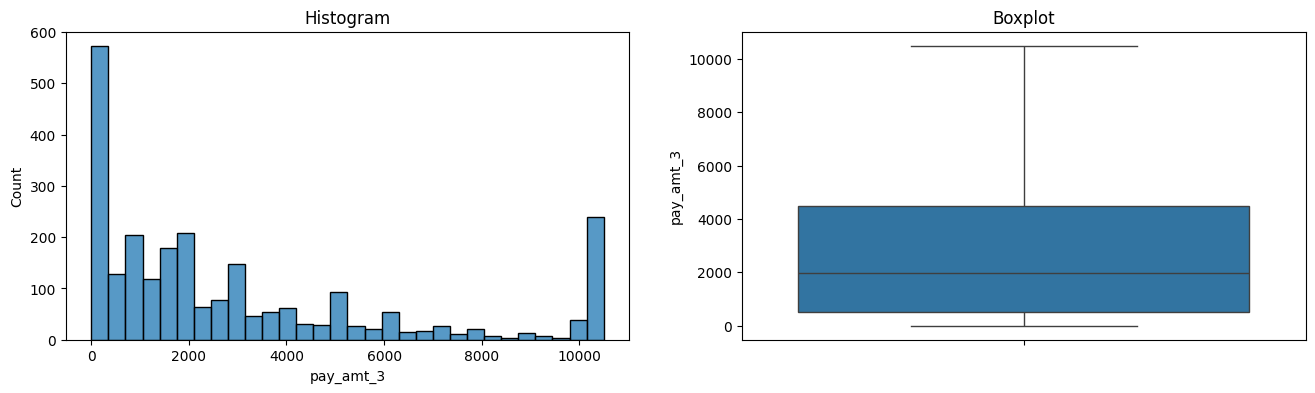

pay_amt_4 - Before Capping


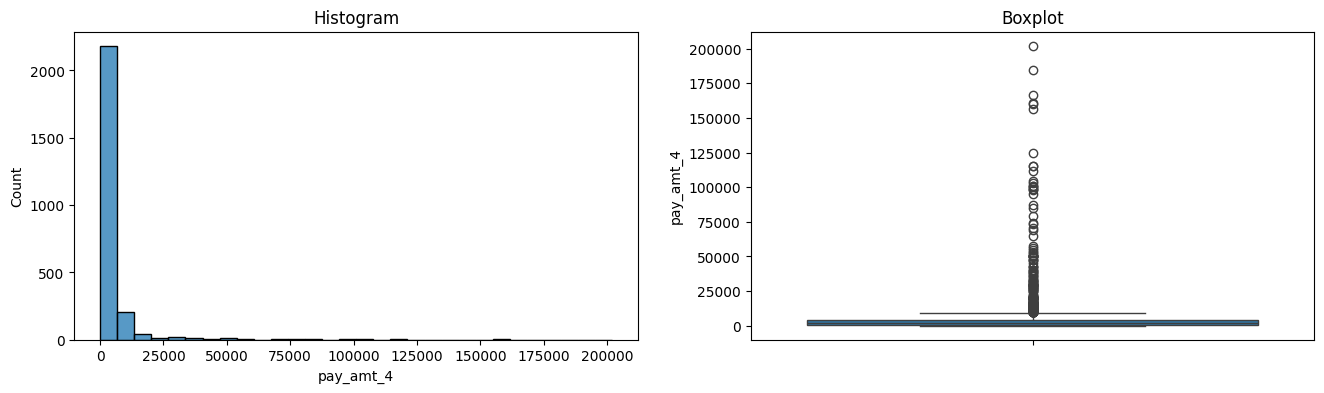


pay_amt_4 - After Capping


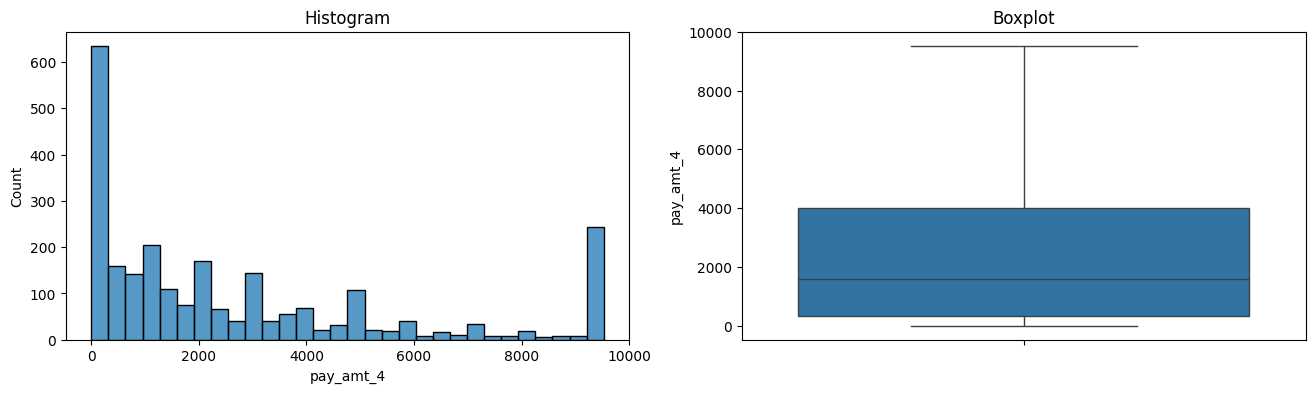

pay_amt_5 - Before Capping


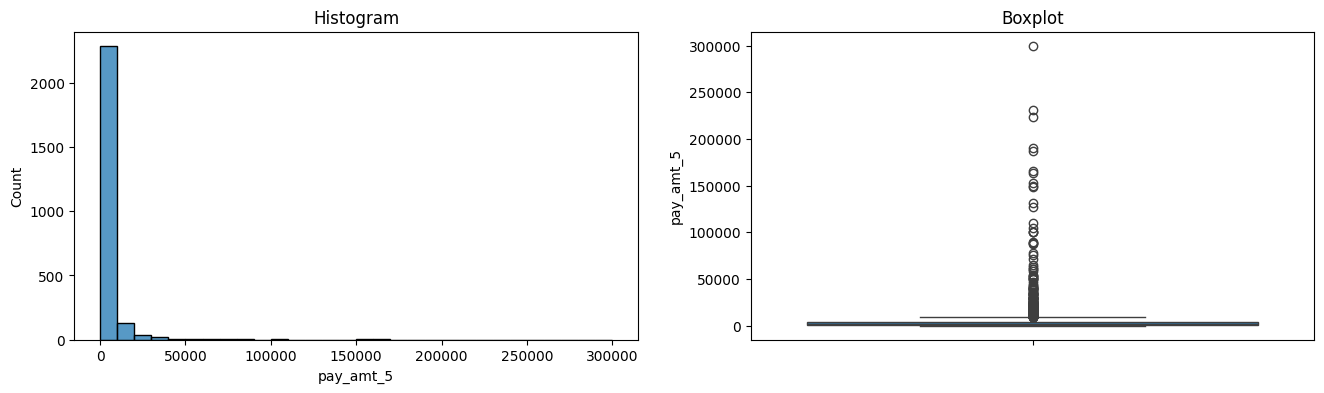


pay_amt_5 - After Capping


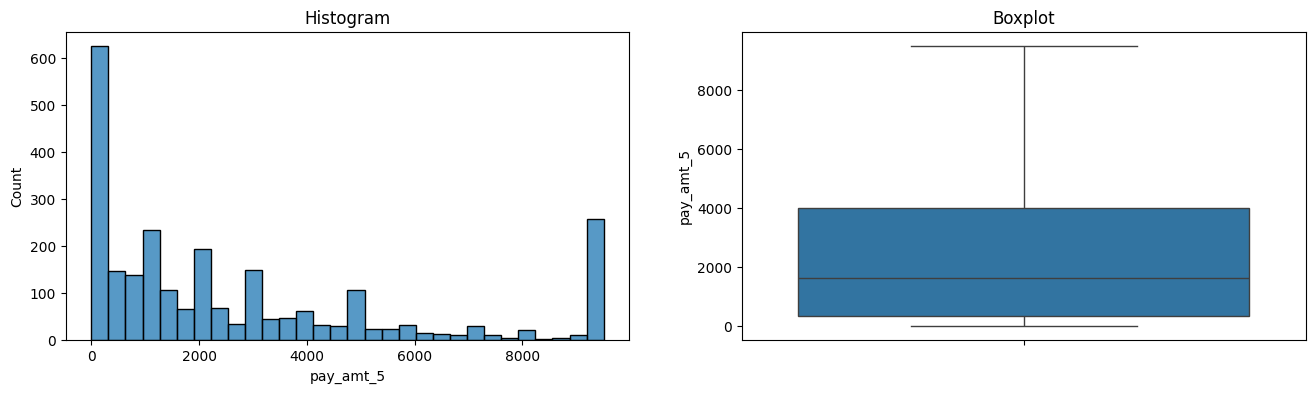

pay_amt_6 - Before Capping


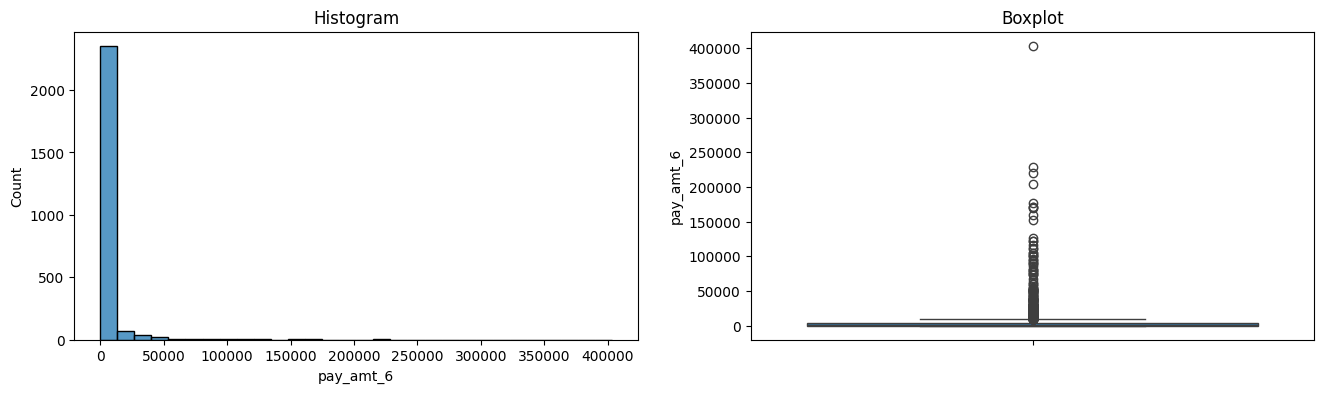


pay_amt_6 - After Capping


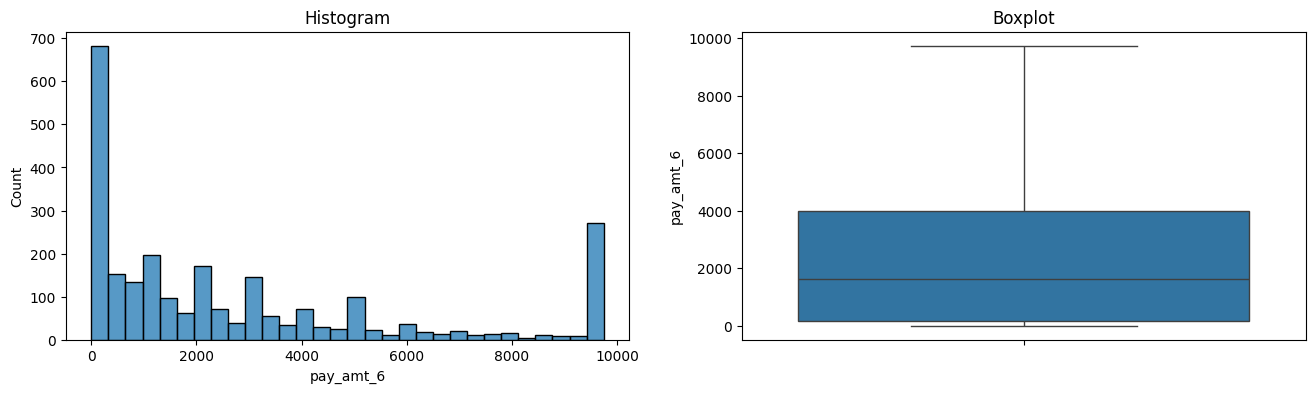

In [26]:
# membuat variabel yang berisi kolom yang mempunyai outlier saja
haveOutlier
# loop
for col in haveOutlier:
    print(f'{col} - Before Capping')
    diagnostic_plots(X_train, col)

    print(f'\n{col} - After Capping')
    diagnostic_plots(X_train_capped, col)

## Feature Selection

In [27]:
# membagi kolom menjadi ordinal, nominal dan numerical untuk mencari adanya korelasi setiap kolom terhadap target
ordinal = ['education_level','pay_0','pay_2','pay_3','pay_4','pay_5','pay_6' ]
nominal = ['sex','marital_status']
numerical = ['limit_balance','age','bill_amt_1',
       'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6']

#### Correlation

In [28]:
# kolom ordinal
ordinal 

# Set the significance level (alpha)
alpha = 0.05

# Kendall untuk ordinal kolom
correlation_df_categorical = pd.DataFrame(columns=['categorical_column', 'tau-statistic', 'p-value', 'is_correlated'])

for cat_column in ordinal:
    # mengubah categori mejadi urutan 
    cat_column_num = X_train_capped[cat_column].astype('category').cat.codes
    y_train_num = y_train.astype('category').cat.codes
    
    tau, p = kendalltau(cat_column_num, y_train_num)
    
    is_correlated = 'Yes' if p < alpha else 'No'
    
    # menggunakan concat untuk menggabungkan dataframes
    correlation_df_categorical = pd.concat([
        correlation_df_categorical,
        pd.DataFrame({'categorical_column': [cat_column], 'tau-statistic': [tau], 'p-value': [p], 'is_correlated': [is_correlated]})
    ], ignore_index=True)

# Print the Kendall's Tau test
correlation_df_categorical

,categorical_column,tau-statistic,p-value,is_correlated
0,education_level,0.069139,2.561118e-04,Yes
1,pay_0,0.301734,6.253582e-61,Yes
2,pay_2,0.234501,1.438325e-36,Yes
3,pay_3,0.220080,2.230304e-32,Yes
4,pay_4,0.206027,1.861044e-28,Yes
5,pay_5,0.207443,9.736908e-29,Yes
6,pay_6,0.187185,7.986312e-24,Yes


In [29]:
# Nominal kolom
nominal

# Set the significance level (alpha)
alpha = 0.05

# chi square untuk nominal kolom
correlation_df_categorical = pd.DataFrame(columns=['categorical_column', 'chi2-statistic', 'p-value', 'is_correlated'])

for cat_column in nominal:
    contingency_table = pd.crosstab(X_train_capped[cat_column], y_train)
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    is_correlated = 'Yes' if p < alpha else 'No'
    
    # menggunakan concat untuk menggabungkan dataframes
    correlation_df_categorical = pd.concat([
        correlation_df_categorical,
        pd.DataFrame({'categorical_column': [cat_column], 'chi2-statistic': [chi2], 'p-value': [p], 'is_correlated': [is_correlated]})
    ], ignore_index=True)

# Print the chi-squared test 
correlation_df_categorical

,categorical_column,chi2-statistic,p-value,is_correlated
0,sex,1.588137,0.207593,No
1,marital_status,2.210849,0.529815,No


In [30]:
# Numerical kolom
numerical

# Set the significance level (alpha)
alpha = 0.05

# spearman untuk numerical kolom
correlation_df_num = pd.DataFrame(columns=['numerical column', 'correlation-statistic', 'p-value', 'is_correlated'])

for cont_column in numerical:
    corr, p = spearmanr(X_train_capped[cont_column], y_train)
    
    is_correlated = 'Yes' if p < alpha else 'No'
    
    correlation_df_num = pd.concat([
        correlation_df_num,
        pd.DataFrame({'numerical column': [cont_column], 'correlation-statistic': [corr], 'p-value': [p], 'is_correlated': [is_correlated]})
    ], ignore_index=True)

# Print the correlation test 
correlation_df_num

,numerical column,correlation-statistic,p-value,is_correlated
0,limit_balance,-0.178829,1.511891e-19,Yes
1,age,0.010550,5.966353e-01,No
2,bill_amt_1,0.003698,8.528420e-01,No
3,bill_amt_2,0.012542,5.292093e-01,No
4,bill_amt_3,0.018681,3.486578e-01,No
5,bill_amt_4,0.022431,2.604223e-01,No
6,bill_amt_5,0.026220,1.883277e-01,No
7,bill_amt_6,0.031379,1.153695e-01,No
8,pay_amt_1,-0.126214,2.058622e-10,Yes
9,pay_amt_2,-0.139300,2.184264e-12,Yes


Berikut kolom kolom yang memiliki korelasi terhadap kolom target:
- Ordinal
    - `education_level`
    - `pay_0`
    - `pay_2`
    - `pay_3`
    - `pay_4`
    - `pay_5`
    - `pay_6`

- Nominal
    - Tidak ada yang berkolerasi

- Numerical
    - `limit_balance`
    - `pay_amt_1`
    - `pay_amt_2`
    - `pay_amt_3`
    - `pay_amt_4`
    - `pay_amt_5`
    - `pay_amt_6`


In [31]:
# memilih kolom yang hanya memiliki korelasi terhadap target
ordinal = ['education_level','pay_0','pay_2','pay_3','pay_4','pay_5','pay_6' ]
numerical = ['limit_balance',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6']
print(f'Kolom yang akan digunakan sebanyak : {len(ordinal+numerical)} total kolom')

Kolom yang akan digunakan sebanyak : 14 total kolom


## Encoding

In [32]:
# Create A Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

# scaller
num_pipeline = make_pipeline(MinMaxScaler())

# encoder
cat_pipeline = make_pipeline(OrdinalEncoder())

preprocessing_pipeline = ColumnTransformer([
    ('pipe_num', num_pipeline, numerical), # numerical column
    ('pipe_cat', 'passthrough', ordinal) # melakukan passthrough karena data ordinal yang sudah berbentuk angka 
])

# Model Definition and Training

Dataset ini akan menggunakan 3 model untuk memprediksi apakah nasabah atau customer dapat membayar atau tidak ketika menggunakan credit card. Model yang digunakan adalah `Logistic Regression`, `KNN`, dan `SVM`

Pengujian train test berdasarkan recall dilakukan karena target dari data adalah mencari nasabah atau customer yang mampu membayar. maka dibutuhkan recall agar dapat me-minimize nilai false negative saat melakukan prediksi. false negative pada data ini adalah ketika customer/nasabah di prediksi dapat membayar namun kenyataannya tidak, maka dari itu dibutuhkannya untuk meminimalisir nilai false negative pada prediksi.

## Logistic Regression

In [33]:
# pipeline untuk Logistic Regression
clfLog = make_pipeline(preprocessing_pipeline, LogisticRegression())
clfLog.fit(X_train_capped, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['limit_balance', 'pay_amt_1',
                                                   'pay_amt_2', 'pay_amt_3',
                                                   'pay_amt_4', 'pay_amt_5',
                                                   'pay_amt_6']),
                                                 ('pipe_cat', 'passthrough',
                                                  ['education_level', 'pay_0',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6'])])),
                ('logisticregression', LogisticRegression())])

In [34]:
# Create a function to check the performance

def performance_check(clf, X, y):
  y_pred = clf.predict(X)

  return recall_score(y, y_pred)

In [35]:
# Check the Performance
# Perform cross-validation
cv_resultslogres = cross_val_score(clfLog, X, y, cv=5, scoring='recall')

print(f"Cross-Validation Recall Scores: {cv_resultslogres}")
print(f"Mean CV Recall Score: {cv_resultslogres.mean()}")
print('Recall - Train : ', performance_check(clfLog, X_train_capped, y_train))
print('Recall - Test  : ', performance_check(clfLog, X_test_capped, y_test))

Cross-Validation Recall Scores: [0.1023622  0.07086614 0.35433071 0.63779528 0.        ]
Mean CV Recall Score: 0.23307086614173228
Recall - Train :  0.29608938547486036
Recall - Test  :  0.32653061224489793


Hasil performance check
- Train : 0.29608938547486036
- Test : 0.32653061224489793
- model memiliki nilai yang stabil namun dengan nilai yang rendah
- nilai konsistensi pada fold yang rendah

## KNN

In [36]:
# pipeline untuk KNN
clfKNN = make_pipeline(preprocessing_pipeline, KNeighborsClassifier())
clfKNN.fit(X_train_capped, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['limit_balance', 'pay_amt_1',
                                                   'pay_amt_2', 'pay_amt_3',
                                                   'pay_amt_4', 'pay_amt_5',
                                                   'pay_amt_6']),
                                                 ('pipe_cat', 'passthrough',
                                                  ['education_level', 'pay_0',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6'])])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [37]:
# Check the Performance
# Perform cross-validation
cv_resultsknn = cross_val_score(clfKNN, X, y, cv=5, scoring='recall')

print(f"Cross-Validation Recall Scores: {cv_resultsknn}")
print(f"Mean CV Recall Score: {cv_resultsknn.mean()}")
print('Recall - Train : ', performance_check(clfKNN, X_train_capped, y_train))
print('Recall - Test  : ', performance_check(clfKNN, X_test_capped, y_test))

Cross-Validation Recall Scores: [0.07874016 0.22834646 0.2519685  0.90551181 0.01574803]
Mean CV Recall Score: 0.29606299212598425
Recall - Train :  0.5121042830540037
Recall - Test  :  0.29591836734693877


Hasil performance check
- Train : 0.5121042830540037
- Test : 0.29591836734693877
- adanya overfitting
- nilai test yang lebih rendah dari model LogRes
- nilai fold yang rendah dan tidak konsisten pada setiap foldnya

## SVM

In [38]:
# pipeline untuk SVM
clfSVM = make_pipeline(preprocessing_pipeline, SVC())
clfSVM.fit(X_train_capped, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['limit_balance', 'pay_amt_1',
                                                   'pay_amt_2', 'pay_amt_3',
                                                   'pay_amt_4', 'pay_amt_5',
                                                   'pay_amt_6']),
                                                 ('pipe_cat', 'passthrough',
                                                  ['education_level', 'pay_0',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6'])])),
                ('svc', SVC())])

In [39]:
# Check the Performance
# Perform cross-validation
cv_results = cross_val_score(clfSVM, X, y, cv=5, scoring='recall')

print(f"Cross-Validation Recall Scores: {cv_results}")
print(f"Mean CV Recall Score: {cv_results.mean()}")
print('Recall - Train : ', performance_check(clfSVM, X_train_capped, y_train))
print('Recall - Test  : ', performance_check(clfSVM, X_test_capped, y_test))

Cross-Validation Recall Scores: [0.1023622  0.04724409 0.43307087 0.75590551 0.        ]
Mean CV Recall Score: 0.2677165354330709
Recall - Train :  0.4450651769087523
Recall - Test  :  0.37755102040816324


Hasil performance check
- Train : 0.4450651769087523
- Test : 0.37755102040816324
- nilai recall yang lebih tinggi dibandingan dengan 2 model sebelumnya
- nilai konsistensi yang rendah dan menunjukkan ketidak stabilan antar fold

## Perbandingan recall score antar model

`Logistic Regression`: 

- Recall - Train :  0.29608938547486036
- Recall - Test  :  0.32653061224489793

`KNN`: 

- Recall - Train :  0.5121042830540037
- Recall - Test  :  0.29591836734693877

`SVM`: 

- Recall - Train :  0.44320297951582865
- Recall - Test  :  0.37755102040816324



Berdasarkan hasil performance check terhadap 3 model, nilai test recall lebih tinggi untuk model SVM dan menunjukkan balance yang lebih baik antar recall dan train set dibandingkan dengan model KNN dan LogRes walaupun nilai tersebut masih dibawah nilai yang diharapkan, maka berdasarkan hasil tersebut, model SVM lah yang akan digunakan.

### Hyperparameter Tuning

In [40]:
from sklearn.pipeline import Pipeline

param_grid = {'svc__C': [0.01, 1.3, 1.4, 1.5, 1.6],
              'svc__gamma': [0.01, 0.05, 0.08, 0.1, 0.2],
              'svc__kernel':['rbf']}

gridsvc = RandomizedSearchCV(clfSVM, param_distributions=param_grid, cv=5, n_iter=20,random_state=46,n_jobs=-1,scoring='recall')
gridsvc.fit(X_train_capped, y_train)

print('Best cross-validation recall : {:.2f}'.format(gridsvc.best_score_))
print('Best parameters : ', gridsvc.best_params_)
print('Test set recall : {:.2f}'.format(gridsvc.score(X_test, y_test)))

# Extract and print cross-validation recall scores for each fold
cv_results = gridsvc.cv_results_
recall_scores = cv_results['mean_test_score']

print(f'Cross-Validation Recall Scores for each fold: {recall_scores}')
print(f'Mean CV Recall Score: {recall_scores.mean()}')

Best cross-validation recall : 0.43
Best parameters :  {'svc__kernel': 'rbf', 'svc__gamma': 0.1, 'svc__C': 1.6}
Test set recall : 0.37
Cross-Validation Recall Scores for each fold: [0.         0.         0.30543441 0.41339564 0.         0.42829699
 0.41154379 0.42268951 0.40969193 0.30728626 0.42268951 0.42268951
 0.41152648 0.42268951 0.         0.43016615 0.         0.40967463
 0.40780547 0.40780547]
Mean CV Recall Score: 0.3016692627206646


**Berdasarkan informasi diatas, dapat disimpulkan bahwa:**<br>
- cross-validation recall score : 0.43
- Best parameter untuk logistic regression adalah :
    - kernel : rbf
    - C : 1.6
    - gamma : 0.1, hal ini menunjukan bahwa setiap titik data memiliki pengaruh yang luas.
- Test set recall : 0.37, hal ini menunjukan model dapat mengidentifikasi sebesar 37% dari data yang belum pernah dilihat oleh model.
- Mean CV :  0.30, hal ini menunjukan konsistensi sebesar 30% dan tidak ada selisih yang jauh diantara fold

In [41]:
# Get Best Estimator
best_estimatorsvc = gridsvc.best_estimator_
best_estimatorsvc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['limit_balance', 'pay_amt_1',
                                                   'pay_amt_2', 'pay_amt_3',
                                                   'pay_amt_4', 'pay_amt_5',
                                                   'pay_amt_6']),
                                                 ('pipe_cat', 'passthrough',
                                                  ['education_level', 'pay_0',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6'])])),
                ('svc', SVC(C=1.6, gamma=0.1))])

Menggunakan Model SVC dengan hyperparameter C sebesar 1.6 dan gamma sebesar 0.1

# Model Evaluation

In [42]:
# Check the Performance before tuning
print('Before Tuning: ')
cv_results = cross_val_score(clfSVM, X, y, cv=5, scoring='recall')

print(f"Cross-Validation Recall Scores: {cv_results}")
print(f"Mean CV Recall Score: {cv_results.mean()}")
print('Recall - Train : ', performance_check(clfSVM, X_train_capped, y_train))
print('Recall - Test  : ', performance_check(clfSVM, X_test_capped, y_test))

Before Tuning: 
Cross-Validation Recall Scores: [0.1023622  0.04724409 0.43307087 0.75590551 0.        ]
Mean CV Recall Score: 0.2677165354330709
Recall - Train :  0.4450651769087523
Recall - Test  :  0.37755102040816324


In [43]:
# Check the Performance after tuning
print('After Tuning: ')
# Extract and print cross-validation recall scores for each fold
cv_results = gridsvc.cv_results_
recall_scores = cv_results['mean_test_score']

print(f'Cross-Validation Recall Scores for each fold: {recall_scores}')
print(f'Mean CV Recall Score: {recall_scores.mean()}')
print('Recall - Train : ', performance_check(best_estimatorsvc, X_train_capped, y_train))
print('Recall - Test  : ', performance_check(best_estimatorsvc, X_test_capped, y_test))

After Tuning: 
Cross-Validation Recall Scores for each fold: [0.         0.         0.30543441 0.41339564 0.         0.42829699
 0.41154379 0.42268951 0.40969193 0.30728626 0.42268951 0.42268951
 0.41152648 0.42268951 0.         0.43016615 0.         0.40967463
 0.40780547 0.40780547]
Mean CV Recall Score: 0.3016692627206646
Recall - Train :  0.46368715083798884
Recall - Test  :  0.3673469387755102


Meskipun recall pada set pengujian sedikit lebih rendah setelah tuning, nilai recall terbaik dari validasi silang menunjukkan bahwa model after tuning mungkin memiliki kinerja yang lebih baik secara keseluruhan dan lebih mampu untuk menggeneralisasi data yang belum pernah dilihat. Oleh karena itu, model after tuning bisa dianggap lebih baik, terutama karena kinerja yang lebih stabil,kemampuan generalisasi yang lebih baik dan nilai konsistensi yang lebih baik.

Perbandingan nilai train test recall sebelum dilakukan hyperparameter tuning dan sesudah menunjukkan:
- perubahan hasil nilai test relatif kecil
- perbedaan pada konsistensi nilai cv, dimana nilai konsistensi lebih besar dan realistis pada setiap foldnya berada pada model yang sudah di tuning

oleh karena itu **model yang akan digunakan adalah SVM dengan hyperparameter tuning**

### Confusion Matrix Before Tuning

Confusion Matrix Before Tuning      : 


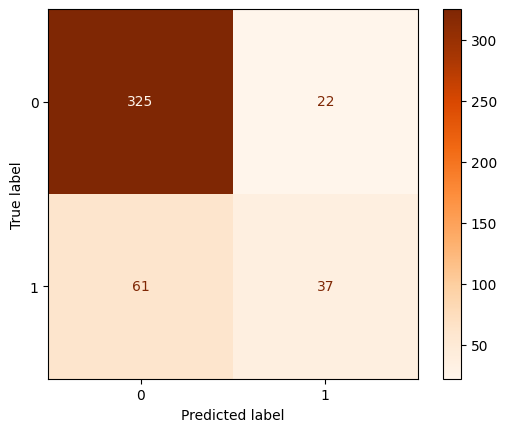

In [44]:
print('Confusion Matrix Before Tuning      : \n', ConfusionMatrixDisplay.from_estimator(clfSVM, X_test_capped, y_test, cmap='Oranges'))

- True Positive : 37
- True Negative : 325
- False Positive : 22
- False Negative : 61

### Confusion Matrix After Tuning

Confusion Matrix After Tuning      : 


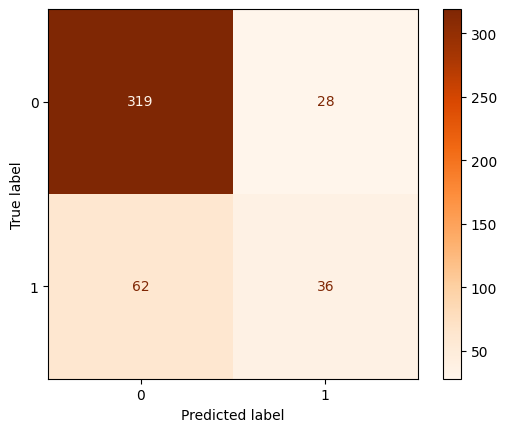

In [45]:
print('Confusion Matrix After Tuning      : \n', ConfusionMatrixDisplay.from_estimator(best_estimatorsvc, X_test_capped, y_test, cmap='Oranges'))

- True Positive : 36
- True Negative : 319
- False Positive : 28
- False Negative : 62

Berdasarkan 2 gambar confusion matrix diatas, didapat model pertama atau model svc tanpa tuning mempunyai score yang lebih baik, tapi berdasarkan analisa sebelumnya, model svc tanpa tuning menunjukkan model yang tidak konsisten, sehingga penggunaan model sesudah tuning lebih baik digunakan dikarenakan nilai konsistensi yang lebih tinggi.

# Model Saving

In [51]:
with open('model.pkl', 'wb') as file:
    pickle.dump(best_estimatorsvc, file)

In [47]:
with open('model.pkl', 'rb') as file:
  modelsvc = pickle.load(file)

# Kesimpulan

- Dataset yang imbalance
- Kolom yang berkorelasi terhadap target adalah :
    Berikut kolom kolom yang memiliki korelasi terhadap kolom target:
    - `education_level`
    - `pay_0`
    - `pay_2`
    - `pay_3`
    - `pay_4`
    - `pay_5`
    - `pay_6`
    - `limit_balance`
    - `pay_amt_1`
    - `pay_amt_2`
    - `pay_amt_3`
    - `pay_amt_4`
    - `pay_amt_5`
    - `pay_amt_6`

- Di antara ketiga model yang diuji, model yang akhirnya digunakan adalah model `SVC` dengan Hyperparameter Tuning
- Hyperparameter tuning yang digunakan adalah :
    - Kernel : `rbf`
    - C : `1.6`
    - Gamma : `0.1`
- Data yang imbalance mengakibatkan model menjadi tidak optimal
- Model SVC memiliki nilai konsistensi sebesar 30%
- Model tidak disarankan untuk digunakan dikarenakan nilai prediksi yang rendah dan konsistensi yang rendah
- Model disarankan untuk dilakukan improvement lagi

# Conceptual Problem

1. **Apakah yang dimaksud dengan coeficient pada logistic regression?**

    Coeficient pada logistic regression adalah seberapa besar pengaruh feature ato varibel selain target terhadap target. nilai koefisien yang positif berarti variabel tersebut meningkatkan kemungkinan nilai target menjadi positif, sedangkan jika nilai koefisien negatif berarti memperbesar kemungkinan nilai target menjadi negatif. semakin besar nilai coeficient maka semakin besar juga nilai target.

2. **Apakah fungsi parameter kernel pada SVM? dan apa contoh kernel SVM?**
    - Parameter kernel pada SVM digunakan untuk mengubah data ke ruang dimensi yang lebih tinggi, sehingga data tersebut lebih mudah dipisahkan.
    - Kernel Poly adalah pemisahan data dengan dimensi yang lebih tinggi dan tanpa menggunakan garis lurus, sehingga hasil menjadi lebih akurat. penggunaan kernel tergantung kepada dataset yang diteliti.

3. **Bagaimana cara memilih `K` yang optimal pada KNN ?**

    Dengan melakukan hyperparameter tuning, lalu mencoba dari rentang nilai tertentu, lalu mengubah nilai parameter mengikuti hasil ke arah yang lebih kecil dan spesifik. semakin bagus nilai K maka boundary semakin smooth. penggunaan nilai ganjil disarankan untuk menentukan nilai `K`

4. **Apa yang dimaksud dengan metrics-metrics berikut : `Accuracy`, `Precision`, `Recall`, `F1 Score`, dan kapan waktu yang tepat untuk menggunakannya ?**

    - `Akurasi` : Penilaian prediksi yang benar dari jumlah total prediksi. Akurasi digunakaan saat jumlah kelas dalam data balance dan semua kesalahan prediksi dianggap sama penting.
    - `Precision` : Penilaian prediksi positif yang benar dari total prediksi positif atau menghitung seberapa presisinya model. Precision digunakan saat ingin meminimalisir nilai False Positive. contoh simpelnya pada Email spam, presisi digunakan agar tidak mendeteksi email penting sebagai email spam
    - `Recall` : Penilaian proporsi prediksi positif yang benar dari total instance positif sebenarnya. Recall digunakan untuk meminimalisir False Negative. contohnya jika beruhubungan dengan nyawa manusia atau penyakit yang berbahaya.
    - `F1 Score` : Merupakan nilai rata rata antar precision dan recall. F1 Score digunakan saat data tidak seimbang dan menganggap nilai Precision dan Recall sama penting.
